## Import Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import imdb 
import pandas as pd
from error_generator import Typo_Butterfingers
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LassoCV
from yellowbrick.regressor import AlphaSelection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from yellowbrick.regressor import PredictionError

anime_data = pd.read_csv("../original-data/new_anime_data1.csv", index_col=0)

anime_data['episodes'] = anime_data['episodes'].replace('Unknown', np.nan)


## Cleaning

In [2]:
l1 = []
l2 = []
l3 = []

anime_data['genre'].fillna('',  inplace=True)
anime_data['overview'].fillna('',  inplace=True)
anime_data['type'].fillna('',  inplace=True)
for index, row in anime_data.iterrows():
    item = row['genre']
    if(pd.isnull(item)):
            item =""
    else:
        if isinstance(item, (list, tuple)):
            item = ','.join(item)
        else:
            item = item.replace(" ","")
            item = item.replace("[","")
            item = item.replace("]","")
            item = item.replace("'","")
    l1.append(item) 

    #HERE STARTS THE BUG     

for index, row in anime_data.iterrows():
    item = row['overview']
    if(pd.isnull(row['overview'])):
            item = ""
    else:
       # for item in anime_data['overview']:
            if isinstance(item, (list, tuple)):
                item = ','.join(item)
            else:
                item = item.replace("[","")
                item = item.replace("]","")
    l2.append(item) 
"""
movie_type = lambda x: 'movie' if x == 'video movie' or x == 'tv movie' else x
series_type = lambda x: 'tv series' if x == 'tv mini series' or x == 'episode' or x == 'tv short' or x == 'video game' else x

print("BEFORE")
print(anime_data.type.value_counts())
anime_data.type = anime_data.type.apply(movie_type)
anime_data.type = anime_data.type.apply(series_type)
print("AFTER")
print("Sezin clean")
print(anime_data.type.value_counts())
"""

for index, row in anime_data.iterrows():
    item = row['type']
    if(item is ''):
    #if(pd.isnull(row['type'])):
        #item = np.nan
        item = ""
    else:    
        if "movie" in item:
            item = "movie"
        else:
            item = "tv series"
    l3.append(item)
"""
print("old clean")
print('movie', l3.count('movie'))
print('tv series', l3.count('movie'))
print('', l3.count(''))
"""
    
anime_data['genre'] = l1   
anime_data['overview'] = l2
anime_data['type'] = l3

#drop duplicate
anime_data.drop_duplicates(inplace = True)

print(anime_data.shape)
print(anime_data.type.value_counts())

(2000, 8)
movie        1002
tv series     990
                8
Name: type, dtype: int64


## Sampling

In [3]:
# sample
anime_train, anime_test = train_test_split(anime_data, test_size=0.2, random_state = 42)
# save train data
anime_train.to_csv("data/trainDataset.csv", index = False,
                  columns = ['anime_id', 'name','genre','type', 'episodes','rating', 'members', 'overview'])
# save test data
anime_test.to_csv("data/testDataset.csv", index = False,
                  columns = ['anime_id', 'name','genre','type', 'episodes','rating', 'members', 'overview'])

## Transformation

In [4]:
import nltk
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
def get_words(x):
    bagofwords=[]
    for i in x:
        if i[1]=='NN':
            bagofwords.append(i[0])
        elif i[1]=='NNS':
            bagofwords.append(i[0])
        elif i[1]=='NNP':
            bagofwords.append(i[0])
        elif i[1]=='NNPS':
            bagofwords.append(i[0])
        elif i[1]=='JJ':
            bagofwords.append(i[0])
        elif i[1]=='JJR':
            bagofwords.append(i[0])
        elif i[1]=='JJS':
            bagofwords.append(i[0])
        elif i[1]=='RB':
            bagofwords.append(i[0])
        elif i[1]=='RBR':
            bagofwords.append(i[0])
        elif i[1]=='RBS':
            bagofwords.append(i[0])
    return bagofwords

def clean_words(x):
    b=nltk.pos_tag(nltk.word_tokenize(x))
    result=get_words(b)
    return result

In [7]:
def get_dummies(train_data_set, test_data_set):
    
    train_index = train_data_set.index
    test_index = test_data_set.index
    
    train_dummies = train_data_set.genre.str.get_dummies(',')
    test_dummies = test_data_set.genre.str.get_dummies(',')
    
    print(type(train_dummies))
    
    train_dummies = pd.DataFrame(data=train_dummies, index=train_index)
    test_dummies = pd.DataFrame(data=test_dummies, index=test_index)
    
    print("Train Dummies",train_dummies.shape)    
    print("Test Dummies",test_dummies.shape)
    
    #### ALİGN
    train_dummies, test_dummies = train_dummies.align(test_dummies, axis=1, join='left')
    
    test_dummies.fillna(0, inplace=True)
    
    print("1", train_dummies.shape, test_dummies.shape)
    
    type_lb = LabelBinarizer()
    fitted_type_lb = type_lb.fit(train_data_set.type.values)
    X_train = type_lb.transform(train_data_set.type.values)
    X_test  = type_lb.transform(test_data_set.type.values)
    
    dfOneHot_train = pd.DataFrame(X_train, columns = ["movie/TVseries" for i in range(X_train.shape[1])], index=train_index)
    dfOneHot_test  = pd.DataFrame(X_test,  columns = ["movie/TVseries" for i in range(X_test.shape[1])], index=test_index)
    
    #index_train = train_data_set.index
    #index_test = test_data_set.index
    #train_data_set = train_data_set.reset_index()
    #test_data_set = test_data_set.reset_index()
    
    # Probably here is the problem
    train_data_set = pd.concat([train_data_set, dfOneHot_train], axis=1, join="outer")
    train_data_set = pd.concat([train_data_set, train_dummies ], axis=1, join="outer")

    test_data_set = pd.concat([test_data_set, dfOneHot_test], axis=1)
    test_data_set = pd.concat([test_data_set, test_dummies],  axis=1)
    
    test_data_set['movie/TVseries'].fillna(0, inplace=True)
    train_data_set['movie/TVseries'].fillna(0, inplace=True)
    print("2", train_data_set.shape, test_data_set.shape)
    return ([train_data_set, test_data_set])

def feature_transformation(train_data_set, test_data_set):
    
    dummieset = get_dummies(train_data_set, test_data_set)
    
    train_data_set = dummieset[0]
    test_data_set = dummieset[1]
     # Here is still the correct shape? y
    #Bag of Words
    print("3", train_data_set.shape, test_data_set.shape)
    
    train_index = train_data_set.index
    test_index = test_data_set.index
    
    summary_doc_train = train_data_set['overview'].fillna("").map(clean_words)
    summary_doc_train =summary_doc_train.apply(','.join)
    
    summary_doc_test = test_data_set['overview'].fillna("").map(clean_words)
    summary_doc_test =summary_doc_test.apply(','.join)
 
    vectorizer = TfidfVectorizer()
    fitted_vectorizer = vectorizer.fit(summary_doc_train)
    overview_feature_train = fitted_vectorizer.transform(summary_doc_train).toarray()
    overview_feature_test = fitted_vectorizer.transform(summary_doc_test).toarray()

    df_train = pd.DataFrame(overview_feature_train, columns = ["word"+ str(int(i)) for i in range(overview_feature_train.shape[1])], index=train_index)
    train_data_set = pd.concat([train_data_set, df_train], axis=1)
    
    df_test = pd.DataFrame(overview_feature_test, columns = ["word"+ str(int(i)) for i in range(overview_feature_test.shape[1])], index=test_index)
    test_data_set = pd.concat([test_data_set, df_test], axis=1)
    
    train_data_set = train_data_set.drop(columns=['anime_id', 'name', 'genre', 'overview', 'type'])
    test_data_set = test_data_set.drop(columns=['anime_id', 'name', 'genre', 'overview', 'type'])
        
    #drop NaN values
    # Why do you need to drop NaN?
    train_data_set.dropna(inplace=True)
    test_data_set.dropna(inplace=True)
    
    train_data_set.fillna(0, inplace=True)
    test_data_set.fillna(0, inplace=True)
    
    return ([train_data_set, test_data_set])

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

# generate features vector
transformed_features = feature_transformation(anime_train, anime_test)
anime_train = transformed_features[0]
anime_test = transformed_features[1]

print(anime_train.shape)
print(anime_test.shape)

# split features vector 
anime_y_train = anime_train['rating']
anime_X_train = anime_train.drop(columns=['rating'])

anime_y_test = anime_test['rating']
anime_X_test = anime_test.drop(columns=['rating'])

<class 'pandas.core.frame.DataFrame'>
Train Dummies (1600, 57)
Test Dummies (400, 49)
1 (1600, 57) (400, 57)
2 (1600, 68) (400, 68)
3 (1600, 68) (400, 68)
(1541, 7165)
(390, 7165)


## Feature Selection

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler

selector = SelectKBest(score_func=f_regression,k=700)#anime_X_test.shape[1]-1)
features = selector.fit(anime_X_train, anime_y_train)

# summarize scores
np.set_printoptions(precision=3)
#print(fit.scores_)

print(anime_X_train.shape)
print(anime_X_test.shape)
anime_X_train = features.transform(anime_X_train)
anime_X_test = features.transform(anime_X_test)
print(anime_X_train.shape)
print(anime_X_test.shape)

scaler = StandardScaler() 

# Apply transform to both the training set and the test set.
anime_X_train = scaler.fit_transform(anime_X_train)  
anime_X_test = scaler.transform(anime_X_test) 

(1541, 7164)
(390, 7164)
(1541, 700)
(390, 700)


## Training - Testing - Evaluation

In [10]:
def training(model, dataset, label):
    clf = model
    clf.fit(dataset, label)
    return clf

def testing_evaluation(model, testset):
    # Make predictions using the testing set
    anime_y_pred = model.predict(testset)
    
    # The mean squared error
    print("Mean squared error: %.2f" % np.sqrt(mean_squared_error(anime_y_test, anime_y_pred)))
    
    visualizer = PredictionError(model)
    visualizer.fit(anime_X_train, anime_y_train)  # Fit the training data to the visualizer
    visualizer.score(anime_X_test, anime_y_test)  # Evaluate the model on the test data
    g = visualizer.poof() 
    
    plt.plot(anime_y_test, '--g', anime_y_pred, '--b')

### Training 

Mean squared error: 1.05


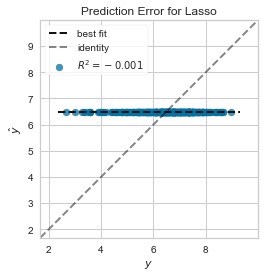

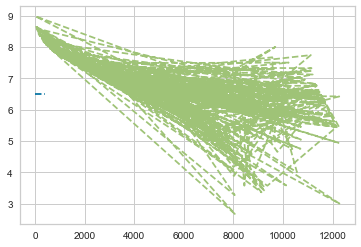

In [11]:
clf = training(model = linear_model.Lasso(), dataset = anime_X_train, label= anime_y_train)
testing_evaluation(clf, anime_X_test)

### Cross Validation

In [12]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
scores = cross_val_score(clf, anime_X_train, anime_y_train, scoring="neg_mean_squared_error", cv=5) 
rmse_scores = np.sqrt(-scores)
display_scores(rmse_scores)

Scores: [0.986 0.986 1.078 0.975 0.954]
Mean: 0.9959716665162077
Standard deviation: 0.042662998376204936


### Grid Search For Hyper Parameter Selection

In [13]:
def checkHP(model, folds, dataset, label):
    parameters = {
                    "alpha" : [1,0,0.1,0.01,0.001,0.0001]
                  }

    gd_sr = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring="neg_mean_squared_error",
                         cv=folds)

    gd_sr.fit(dataset, label)  
    
    best_parameters = gd_sr.best_params_  
    print("best parameters are: ", best_parameters)

    best_result = gd_sr.best_score_  
    print("The mean squared Error is: %.2f" % -best_result) 
    
checkHP(clf, 10, anime_X_train, anime_y_train) 

best parameters are:  {'alpha': 0.1}
The mean squared Error is: 0.87


c:\users\larat\appdata\local\programs\python\python37-32\lib\site-packages\pattern-3.6-py3.7.egg\pattern\text\en\..\..\..\..\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mean squared error: 0.95


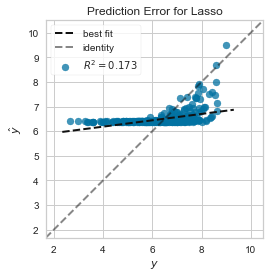

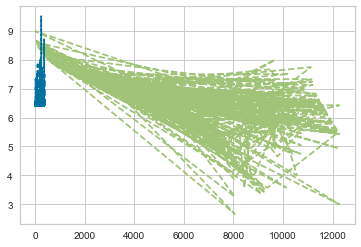

In [14]:
clf = training(model = linear_model.Lasso(alpha = 0.1), dataset = anime_X_train, label= anime_y_train)
testing_evaluation(clf, anime_X_test)